# Laplacian experiment

This code attempts to learn a quadratic prior $J(x) = ||x-\mu||^{2}_{2}/2alpha$.

Instead, we suppose we have access to values of $S(y) = min_{x \in \R} \{0.5*||x-y||^{2}_{2} + J(x)\}$

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

# Parameters and auxiliary functions

In [11]:
# Dimension of the LPN
dim = 1

# Parameters of the prior J(x) = (0.5/alpha)norm{x-mu}^{2}_{2}
mu = 0.0
alpha = 1.0

# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

def prox_true(x,mu,alpha):
    val = (mu + alpha*x)/(1+alpha)
    return val

def cvx_true(x,mu,alpha):
    S = 0.5*pow(mu-x,2)/(1+alpha)
    val = 0.5*pow(x,2) - S
    return val

def prior_true(x,mu,alpha):
    val = 0.5*pow(x-mu,2)/alpha
    return val

# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)
    
    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, prox_true(xi,mu,alpha), "--", label="tikhonov.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    plt.plot(xi, cvx_true(xi,mu,alpha), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, prior_true(xi,mu,alpha), "--", label=r"$\ell_{2}^{2}$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()


## Model parameters

In [12]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# Generate sample points uniformly in the interval [a,b]
bsize = 200
a = -5.0
b = 5.0

input = torch.distributions.uniform.Uniform(a, b, validate_args=None).sample((bsize,))
input = input.unsqueeze(1).to(device)

# Evaluate the solution of the HJ PDE at these points
# Convert to pytorch
cvx_samples = cvx_true(input,mu,alpha)

## Training function

In [13]:
def single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss=None):
    # Compute the convex function from the input
    cvx_out = lpn_model.scalar(input)

    

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 12.401381492614746
iteration 0 loss 94.82304382324219
iteration 500 loss 1.1812024116516113
iteration 1000 loss 0.6169924736022949
iteration 1500 loss 0.535237193107605
iteration 2000 loss 0.45110413432121277
iteration 2500 loss 0.3575300872325897
iteration 3000 loss 0.2592696249485016
iteration 3500 loss 0.1687374860048294
iteration 4000 loss 0.09463310241699219
iteration 4500 loss 0.043292902410030365
iteration 5000 loss 0.01953691430389881
iteration 5500 loss 0.009496903046965599
iteration 6000 loss 0.0047785695642232895
iteration 6500 loss 0.0025137451011687517
iteration 7000 loss 0.0014569375198334455
iteration 7500 loss 0.0009224783862009645
iteration 8000 loss 0.0006067883805371821
iteration 8500 loss 0.0003932098625227809
iteration 9000 loss 0.00024639751063659787
iteration 9500 loss 0.0001445686793886125
iteration 10000 loss 8.311294368468225e-05
iteration 10500 loss 4.956648626830429e-05
iteration 11000 loss 3.086890501435846e-05
iteration 11500 loss 2.004926

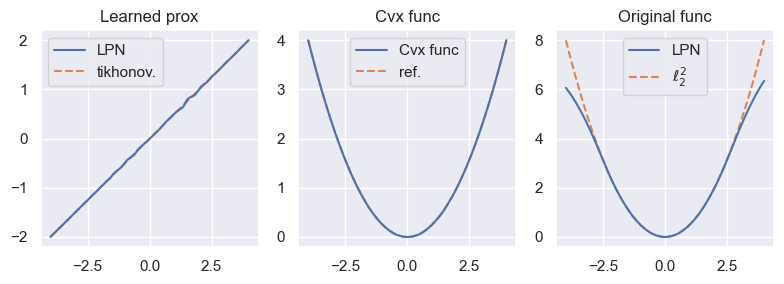

In [14]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 2.778416395187378
iteration 0 loss 9.122745513916016
iteration 500 loss 0.7764868140220642
iteration 1000 loss 0.32577618956565857
iteration 1500 loss 0.23930317163467407
iteration 2000 loss 0.09177428483963013
iteration 2500 loss 0.019451476633548737
iteration 3000 loss 0.007562600541859865
iteration 3500 loss 0.00617502024397254
iteration 4000 loss 0.004531376995146275
iteration 4500 loss 0.0038182372227311134
iteration 5000 loss 0.00408007251098752
iteration 5500 loss 0.003633934073150158
iteration 6000 loss 0.0027444881852716208
iteration 6500 loss 0.0024070150684565306
iteration 7000 loss 0.0028182286769151688
iteration 7500 loss 0.003742063883692026
iteration 8000 loss 0.002851717406883836
iteration 8500 loss 0.0025943464133888483
iteration 9000 loss 0.0020121207926422358
iteration 9500 loss 0.002559021348133683
iteration 10000 loss 0.002216131193563342
iteration 10500 loss 0.002832744037732482
iteration 11000 loss 0.0021508566569536924
iteration 11500 loss 0.001

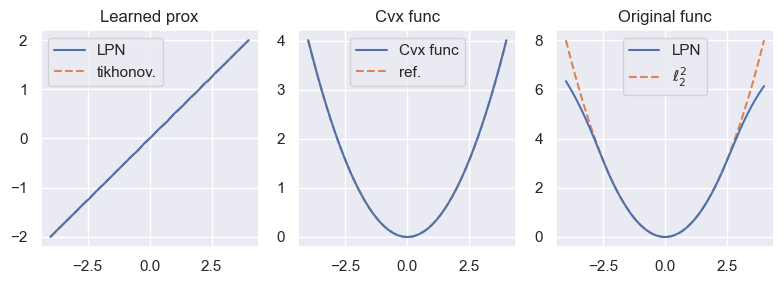

In [15]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 1

for i in range(1):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(20000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma=10

iteration 0 loss 0.06117730215191841


iteration 500 loss 0.0006893566460348666
iteration 1000 loss 0.00013664393918588758
iteration 1500 loss 5.1733852160396054e-05
iteration 2000 loss 2.2827982320450246e-05
iteration 2500 loss 1.0384917004557792e-05
iteration 0 loss 4.623532277037157e-06
iteration 500 loss 4.234910193190444e-06
iteration 1000 loss 3.795027623709757e-06
iteration 1500 loss 3.3169985726999585e-06
iteration 2000 loss 2.814829258568352e-06
iteration 2500 loss 2.3069978851708584e-06
mse 5.344388961791992
mse 3.354213237762451
mse 2.4237029552459717
mse 1.6726752519607544
mse 1.1375035047531128
mse 0.7208319902420044
mse 0.47017157077789307
mse 0.4301520884037018
mse 0.42057347297668457
mse 0.41664332151412964
final mse 0.41437920928001404
(1000,) (1000,) (1000,) (1000,)


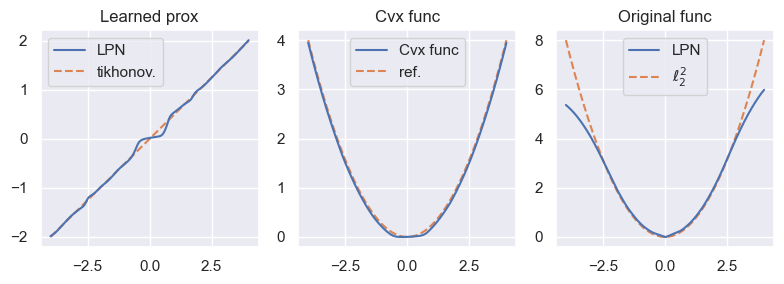

In [16]:
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

loss_type = 0
gamma_loss = 10

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(3000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=5

iteration 0 loss 7.2342159000982065e-06


iteration 500 loss 6.430148914660094e-06
iteration 1000 loss 5.585253347817343e-06
iteration 1500 loss 4.739165433420567e-06
iteration 2000 loss 3.9219858081196435e-06
iteration 2500 loss 3.166496753692627e-06
iteration 3000 loss 2.4962425868579885e-06
iteration 3500 loss 1.9231438272981904e-06
iteration 4000 loss 1.4463066690950654e-06
iteration 4500 loss 1.0642409051797586e-06
iteration 5000 loss 7.662176813028054e-07
iteration 5500 loss 5.438923835754395e-07
mse 5.344301700592041
mse 3.4716131687164307
mse 2.436230421066284
mse 1.6953152418136597
mse 1.1199876070022583
mse 0.7030654549598694
mse 0.450836181640625
mse 0.38324522972106934
mse 0.36959657073020935
mse 0.36487147212028503
final mse 0.3625112771987915
(1000,) (1000,) (1000,) (1000,)


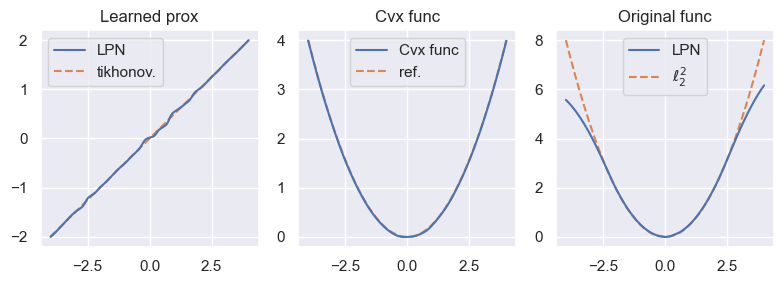

In [17]:
gamma_loss = 5

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(6000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=1

iteration 0 loss 9.62078593147453e-06
iteration 500 loss 7.342100161622511e-06
iteration 1000 loss 6.07222318649292e-06
iteration 1500 loss 5.136132131156046e-06
iteration 2000 loss 4.458129296835978e-06
iteration 2500 loss 3.910362920578336e-06
iteration 3000 loss 3.477633072179742e-06
iteration 3500 loss 3.170370973748504e-06
iteration 4000 loss 2.888143171730917e-06
iteration 4500 loss 2.633631311255158e-06
iteration 5000 loss 2.4625658170407405e-06
iteration 5500 loss 2.308487864866038e-06
iteration 6000 loss 2.1687149001081707e-06
iteration 6500 loss 2.079010073430254e-06
iteration 7000 loss 2.0104646409890847e-06
iteration 7500 loss 1.9386411622690503e-06
iteration 8000 loss 1.8647313027031487e-06
iteration 8500 loss 1.8081068446917925e-06
iteration 9000 loss 1.7637014479987556e-06
iteration 9500 loss 1.716911810945021e-06
mse 5.3442206382751465
mse 3.6727120876312256
mse 2.4987573623657227
mse 1.7326821088790894
mse 1.1345891952514648
mse 0.7122046947479248
mse 0.456005036830902

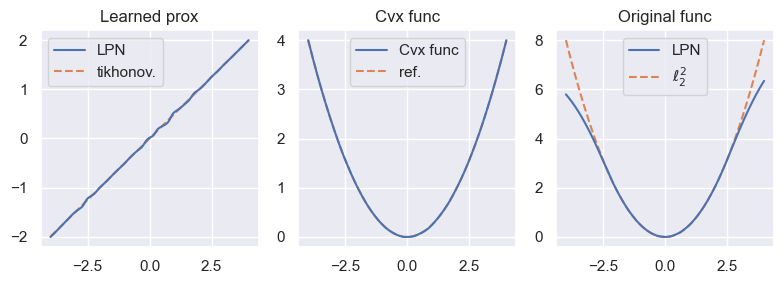

In [18]:
gamma_loss = 1

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(10000):
    single_iteration(i, bsize, lpn_model, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)